<font size="6" color='#03D3E8'>
    <b>1. Group 2 Assignment Report</b>         
</font>

## “Search for New Earths” Exoplanet Data Analysis & Prediction Model 

#### Collaborators in no order:
- Darren Barber, 
- Karren Parra, 
- Mariuxi Leon, 
- Shivayogi Itagi Eswarappa, 
- Waheed Faizi, 
- Yu Guan 

<font size="6" color='#03D3E8'>
    <b>2. Abstract</b>         
</font>

This report analyses "Exoplanet" dataset collected from Kepler Space Observatory. Kepler collected light flux of several thousands of stars over a period of time with the purpose to search for ‘Earth sized’ planets outside our solar system. Out of several known methods to search for exoplanets, Kepler used “Transit” method. Transit method is based on light flux variation to determine if a star has a potential planetary system orbiting it. From Data Science point of view, this is a classification type of problem. Team explored various classification techniques learned in this course including pre-processing.

This Jupyter notebook is the analysis and prediction code supporting the final report submitted towards group assignment, and is submitted as part of the requirements to satisfy completion of the coursework for: Data Science 4 Machine Learning, UNIVERSITY OF WATERLOO


<font size="6" color='#03D3E8'>
    <b>3. Descriptive Analysis</b>         
</font>

- The data has already split into 2 datasets - Train and Test

#### Train dataset 
- Total 5087 records, 3198 features.
- Frist column 'LABEL' is the target feature. 
- Rest of the features (from Columns 2 to 3198) are the flux values recorded by the Kepler telescope over time.
- There are 37 confirmed exoplanet-stars and 5050 non-exoplanet-stars.

#### Test dataset
- Total of 570 records, 3198 features.
- Frist column 'LABEL' is the target feature. 
- Rest of the features (from Columns 2 to 3198) are the flux values recorded by the Kepler telescope over time.
- There are 5 confirmed exoplanet-stars and 565 non-exoplanet-stars.
- Overall Test dataset represents 10% of the total dataset 

<font size="5" color='#03D3E8'>
    <b>3.1 Loading Required Packages</b>         
</font> 

In [1]:
# YOUR CODE HERE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import os
import datetime as dt

from scipy.stats import ks_2samp
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import random
import lightgbm as lgb

from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV, learning_curve 
from sklearn.metrics import recall_score,cohen_kappa_score,roc_curve, auc,accuracy_score,confusion_matrix,f1_score,precision_score,roc_auc_score,roc_curve
from sklearn.metrics import mean_squared_error
from sklearn import metrics 
from sklearn.svm import LinearSVR
from sklearn import ensemble
from sklearn.linear_model import LogisticRegression

In [ ]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

<font size="5" color='#03D3E8'>
    <b>3.2 Reading The Data Sets</b>         
</font> 

Data source: https://www.kaggle.com/keplersmachines/kepler-labelled-time-series-data

In [ ]:
#Use your directory work, the data do not need a special treatment to read
#Train=pd.read_csv('D:\\mis documentos\\Data Science Certificate\\Module 4 - Machine Learning\\Group Assignment\\exoTrain.csv',sep=',')
#Test=pd.read_csv('D:\\mis documentos\\Data Science Certificate\\Module 4 - Machine Learning\\Group Assignment\\exoTest.csv',sep=',')
#path = 'C:/Users/m_leo/Documents/Mariuxi/A_Mariuxi/Data Science 4 Machine Learning/Project/'
path=''
train = pd.read_csv(path+'exoTrain.csv',sep=',')
test = pd.read_csv(path+'exoTest.csv',sep=',')

<font size="5" color='#03D3E8'>
    <b>3.3 Basic Analysis and Data Characteristics</b>         
</font> 

In [ ]:
train.head(5)

In [ ]:
test.head(5)

In [ ]:
print("Train dataset shape: ", train.shape)
print("Test dataset shape: ", test.shape)

In [ ]:
print('Missing Data in Training set: ', train.isnull().sum().sum())
print('Missing Data in Test set: ', test.isnull().sum().sum())

In [ ]:
print('Training set info: ')
train.info()
print('\nTest set info: ')
test.info()

In [ ]:
train.dtypes

In [ ]:
test.dtypes

<font size="5" color='#03D3E8'>
    <b>3.4 Features and Class Distribution</b>         
</font> 

#### Features
- Dependent/Target feature 'LABEL'. Value of '2' means a star is an exoplanet star and '1' is a non-exoplanet-star.
- Independent features 'FLUX1' through 'FLUX3197'. The light intensity recorded for each star, at a different point in time.

In [ ]:
feature_list = list(train.columns.values)
len(feature_list)

In [ ]:
# creating 'label' feature as 'target'
target=feature_list[0] 
# Rest of the columns as findependent features
features=list(feature_list[1:(len(feature_list)-1)]) 
print("Target feature:", target)
print("Number of independent features:", len(features))

#### Class Distribution
Train
- 1: 5050 - 99.27%
- 2: 37 - 0.73%

Test
- 1: 565 - 99,12%
- 2: 5 - 0.88%

#### Data Characteristics

* The data describe the change in flux (light intensity) of 5,087 stars used in train set and has a total of 570 stars in test set
* There is no presence of NAN values over the measures
* Extreme values presented in the variables reference in minimum and maximum values
* High variables dimension that require a dimension reduction technique, in this case, it will be used Principal Component Analysis PCA


<font size="5" color='#03D3E8'>
    <b>3.5 Plotting Sample Data</b>         
</font> 

in order to get a better idea of what the data looks like.

**Scaling:**
as we can see with the graph below, the range of data is vast. going from anywhere from -500000 all the way to 1500000. and it seems like the purple line (flux 5) has a much different scale than some of the other line. using a MinMaxScaler() should help fix this and make the data more consistent across all features.

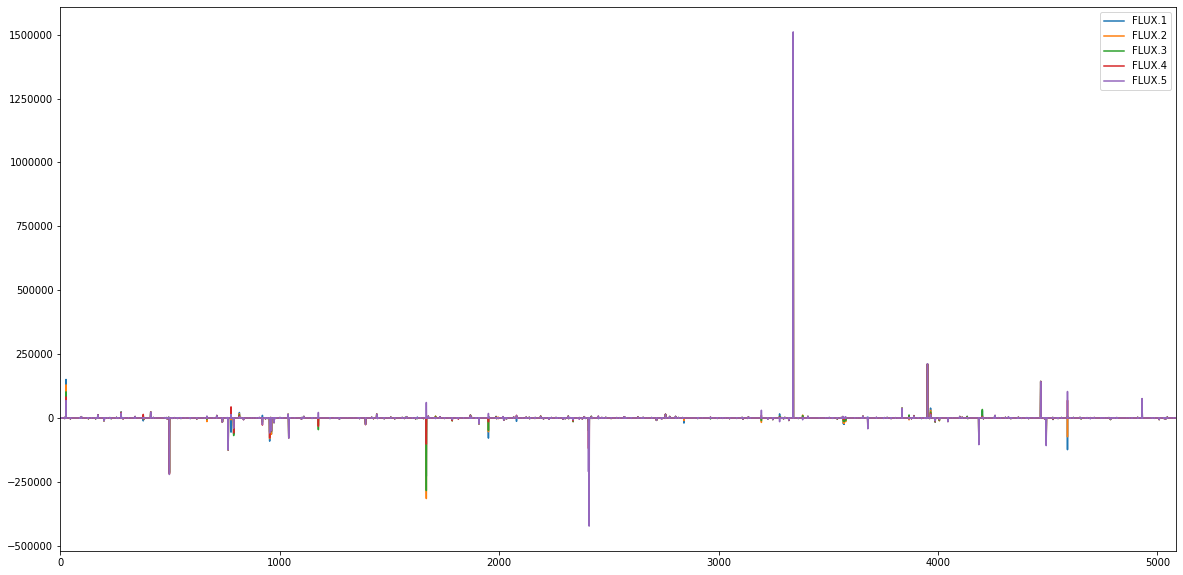

In [13]:
sample = train[['FLUX.1','FLUX.2','FLUX.3','FLUX.4','FLUX.5']]
sample.plot(figsize=(20,10))

In [14]:
cont_vars = list(train.drop(['LABEL'],1).columns)

In [15]:
#NUMERICAL PIPELINE: scaling
num_scl_step = ('scale', MinMaxScaler())
num_steps = [num_scl_step]
num_pipe = Pipeline(num_steps)
num_transformers = [('num', num_pipe, cont_vars)]

In [16]:
ct = ColumnTransformer(transformers=num_transformers)
ct.fit(train[cont_vars])
X_train = ct.transform(train[cont_vars])
ct.fit(test[cont_vars])
X_test = ct.transform(test[cont_vars])


y_train = train['LABEL'].values
y_test = test['LABEL'].values

In [17]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(5087, 3197) (570, 3197) (5087,) (570,)


As you can see below the data is much easier to visualize with a more consistent scale between the features. this will also help us in our predictive models.

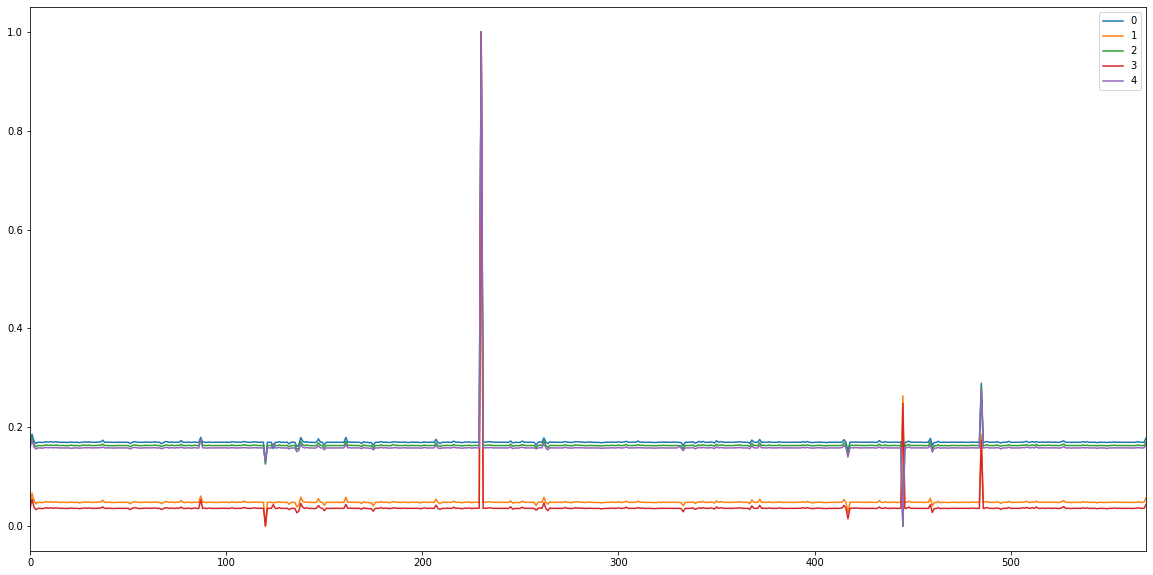

In [18]:
random = pd.DataFrame(data=X_test)
sample2  = random.iloc[:, 0:5]
sample2.plot(figsize=(20,10))

<font size="5" color='#03D3E8'>
    <b>3.6 Stars with Exoplanetary systems and without Exoplanetary system</b>         
</font> 

<font size="4" color='#03D3E8'>
    <b>3.6.1 Exoplanet Stars</b>         
</font> 

In [19]:
# Stars with exoplanets
train_with=train.loc[train['LABEL']==2]
train_with.head(3)

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,2,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67


<font size="4" color='#03D3E8'>
    <b>3.6.2 Non-Exoplanet Stars</b>         
</font> 

In [20]:
train_without=train.loc[train['LABEL']==1]
train_without.head(3)

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
37,1,-141.22,-81.79,-52.28,-32.45,-1.55,-35.61,-23.28,19.45,53.11,...,-50.79,-22.34,-36.23,27.44,13.52,38.66,-17.53,31.49,31.38,50.03
38,1,-35.62,-28.55,-27.29,-28.94,-15.13,-51.06,2.67,-5.21,9.67,...,-43.98,-38.22,-46.23,-54.40,-23.51,-26.96,-3.95,-0.34,10.52,-7.69
39,1,142.40,137.03,93.65,105.64,98.22,99.06,86.40,60.78,45.18,...,-0.99,-3.03,-30.27,-24.22,-35.10,-39.64,23.78,23.40,-0.50,0.97


<font size="4" color='#03D3E8'>
    <b>3.6.3 Flux Diagram of Non-Exoplanet Star</b>         
</font> 

This is to see the typical characteristic of a non-exoplanet star. Expectation is that there is no dimming or dip in curve as there should be nothing blocking the star over the entire observation period.

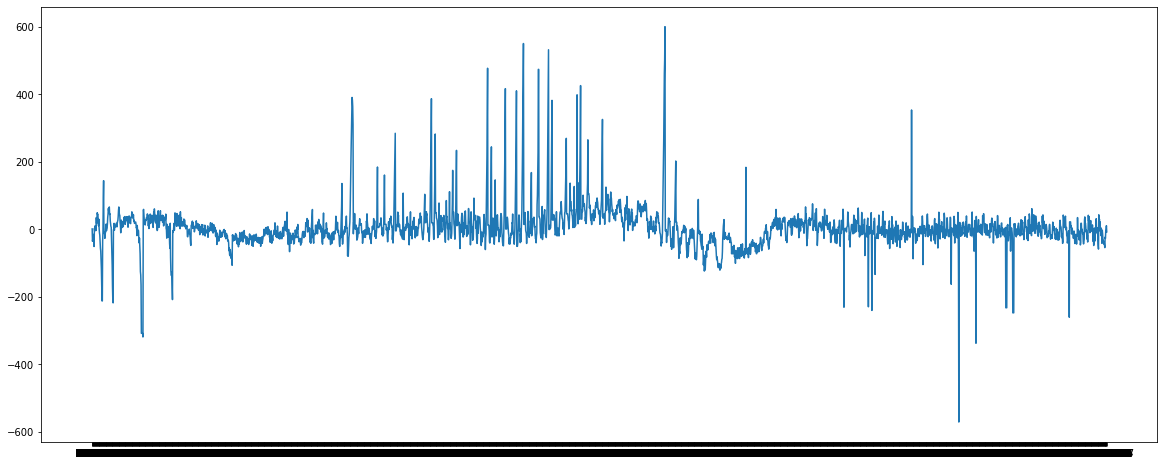

In [21]:
plt.figure(figsize=(20,8))
plt.plot(train_without.iloc[1])

<font size="4" color='#03D3E8'>
    <b>3.6.4 Flux Diagram of Exoplanet Star</b>         
</font> 


If a star is an exoplanet star, then we should observe a periodical dip in the plot. The dip represents planet orbiting teh start that blocks the light from the star when it passes in front of it (planetary eclipse).

There are other additional inferences that can be made as,
1. The amount of dip represents the size of the planet.
2. The frequency of the dip indicates the time taken by the planet to orbit the star
3. The duration of each dip may give a measure of planet's diameter

There are many other inferences that can be derived like the pattern of dips could indicate if there are more than one planet, their orbital disctance etc. For this assignment purpose we will not be going deep into domain, but limit it to how Data Science and Machine Learning can be applied to astonomical studies.

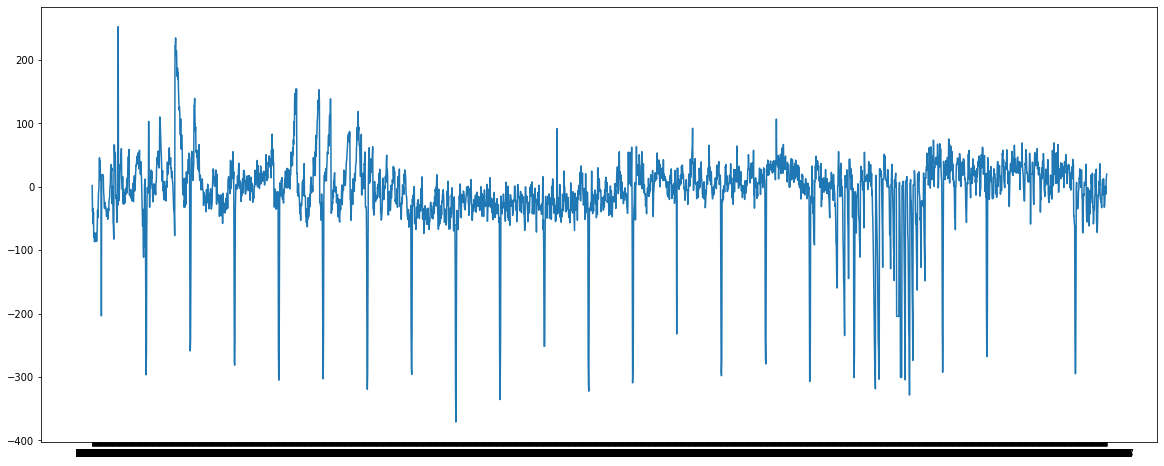

In [22]:
plt.figure(figsize=(20,8))
plt.plot(train_with.iloc[1])

In [23]:
train.groupby(['LABEL']).count()

,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,FLUX.10,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
LABEL,,,,,,,,,,,,,,,,,,,,,
1,5050,5050,5050,5050,5050,5050,5050,5050,5050,5050,...,5050,5050,5050,5050,5050,5050,5050,5050,5050,5050
2,37,37,37,37,37,37,37,37,37,37,...,37,37,37,37,37,37,37,37,37,37


<font size="4" color='#03D3E8'>
    <b>3.6.5 More Validation of Exoplant and Non-Exoplanet Stars</b>         
</font> 

In [24]:
data_no = train.loc[train['LABEL'] == 1]
data_yes = train.loc[train['LABEL'] == 2]
data_no = data_no.iloc[:37,1:].T
data_yes = data_yes.T

Let's take a look at the shape of the flux patterns for the suns with confirmed exoplanets 

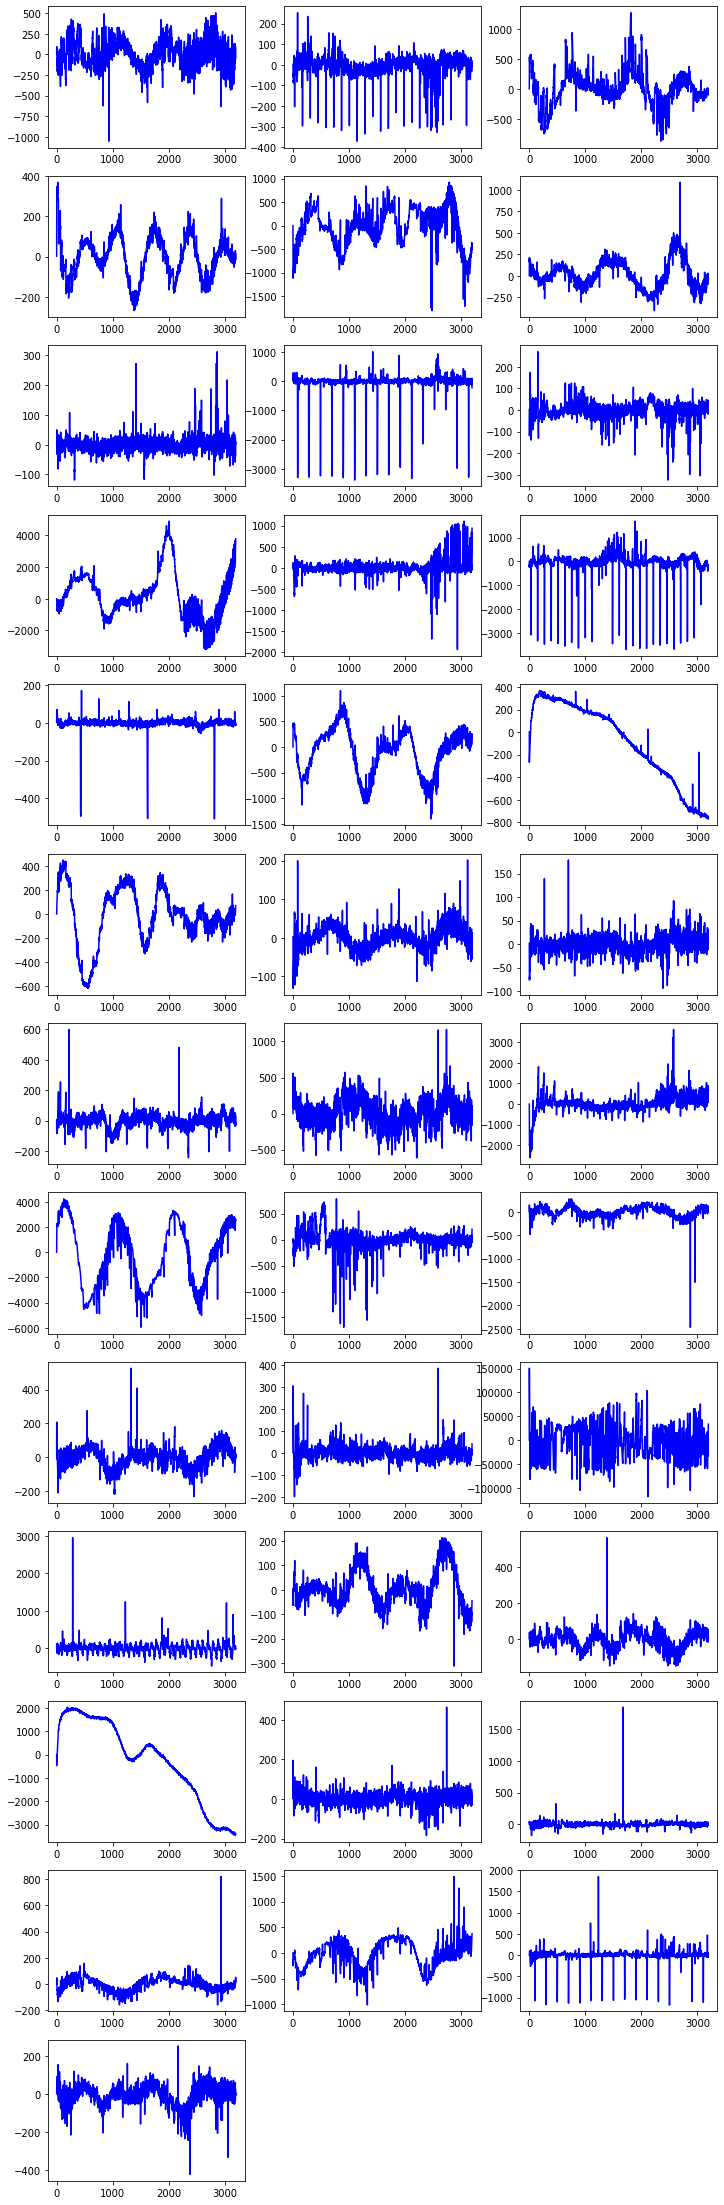

In [25]:
x = np.array(range(3198))    
fig = plt.figure(figsize=(12,40))
for i in range(37):
    ax = fig.add_subplot(13,3,i+1)
    ax.plot(x,data_yes.iloc[:,i], color='blue')

Now lets compare with a sample of suns with no exoplanets

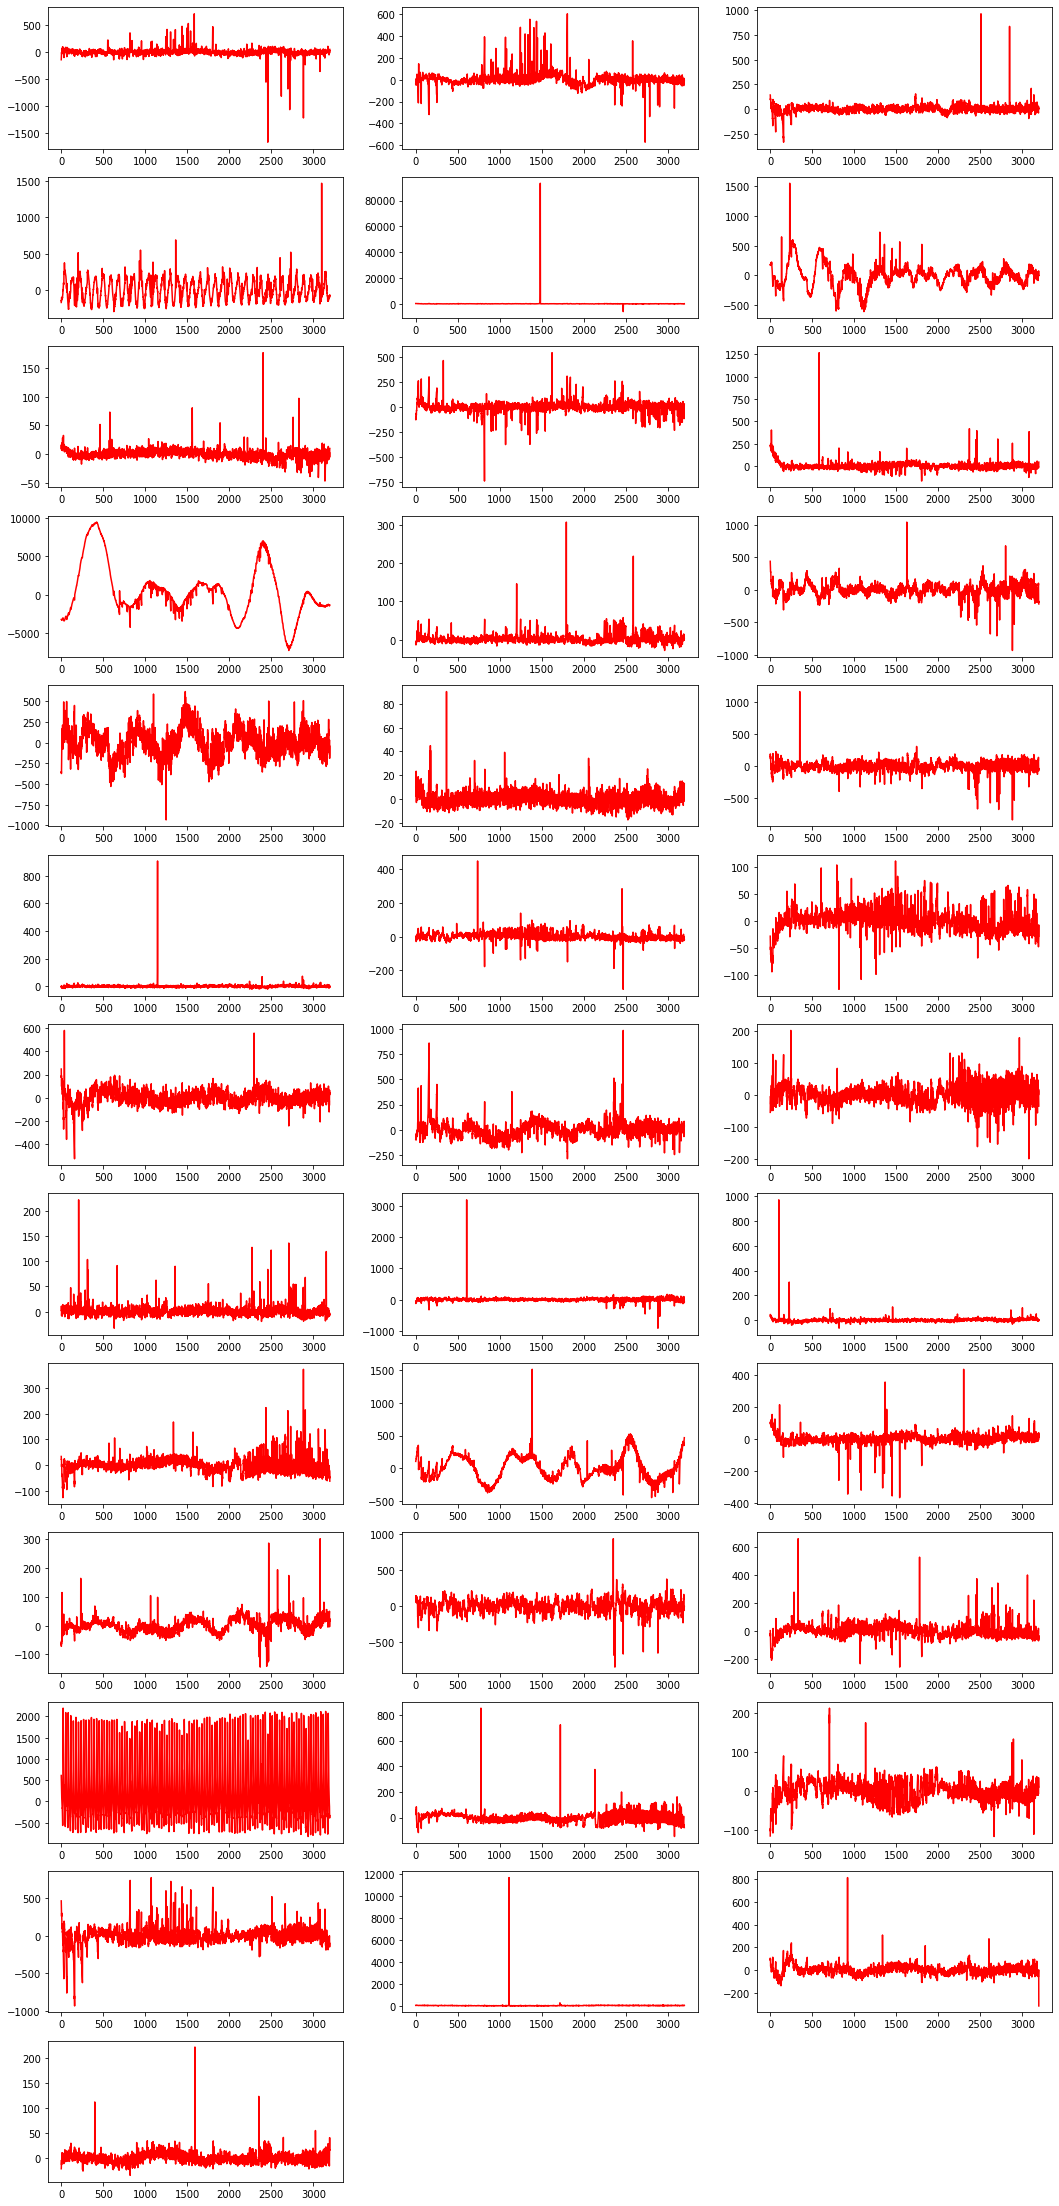

In [26]:
x = np.array(range(3197))    
fig = plt.figure(figsize=(18,40))
for i in range(37):
    ax = fig.add_subplot(13,3,i+1)
    ax.plot(x,data_no.iloc[:,i], color='red')

According with the min and max values of the summary data there are extreme values around the orden $-10^5$ and $10^6$. It will be used MinMax transformation over the dataset. 

<font size="5" color='#03D3E8'>
    <b>3.7 Sample Plots</b>         
</font> 

<font size="4" color='#03D3E8'>
    <b>3.7.1 Pairplots</b>         
</font> 

(5087, 21)


C:\Users\shiva\.conda\envs\DS1\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\shiva\.conda\envs\DS1\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


<Figure size 1440x1440 with 0 Axes>

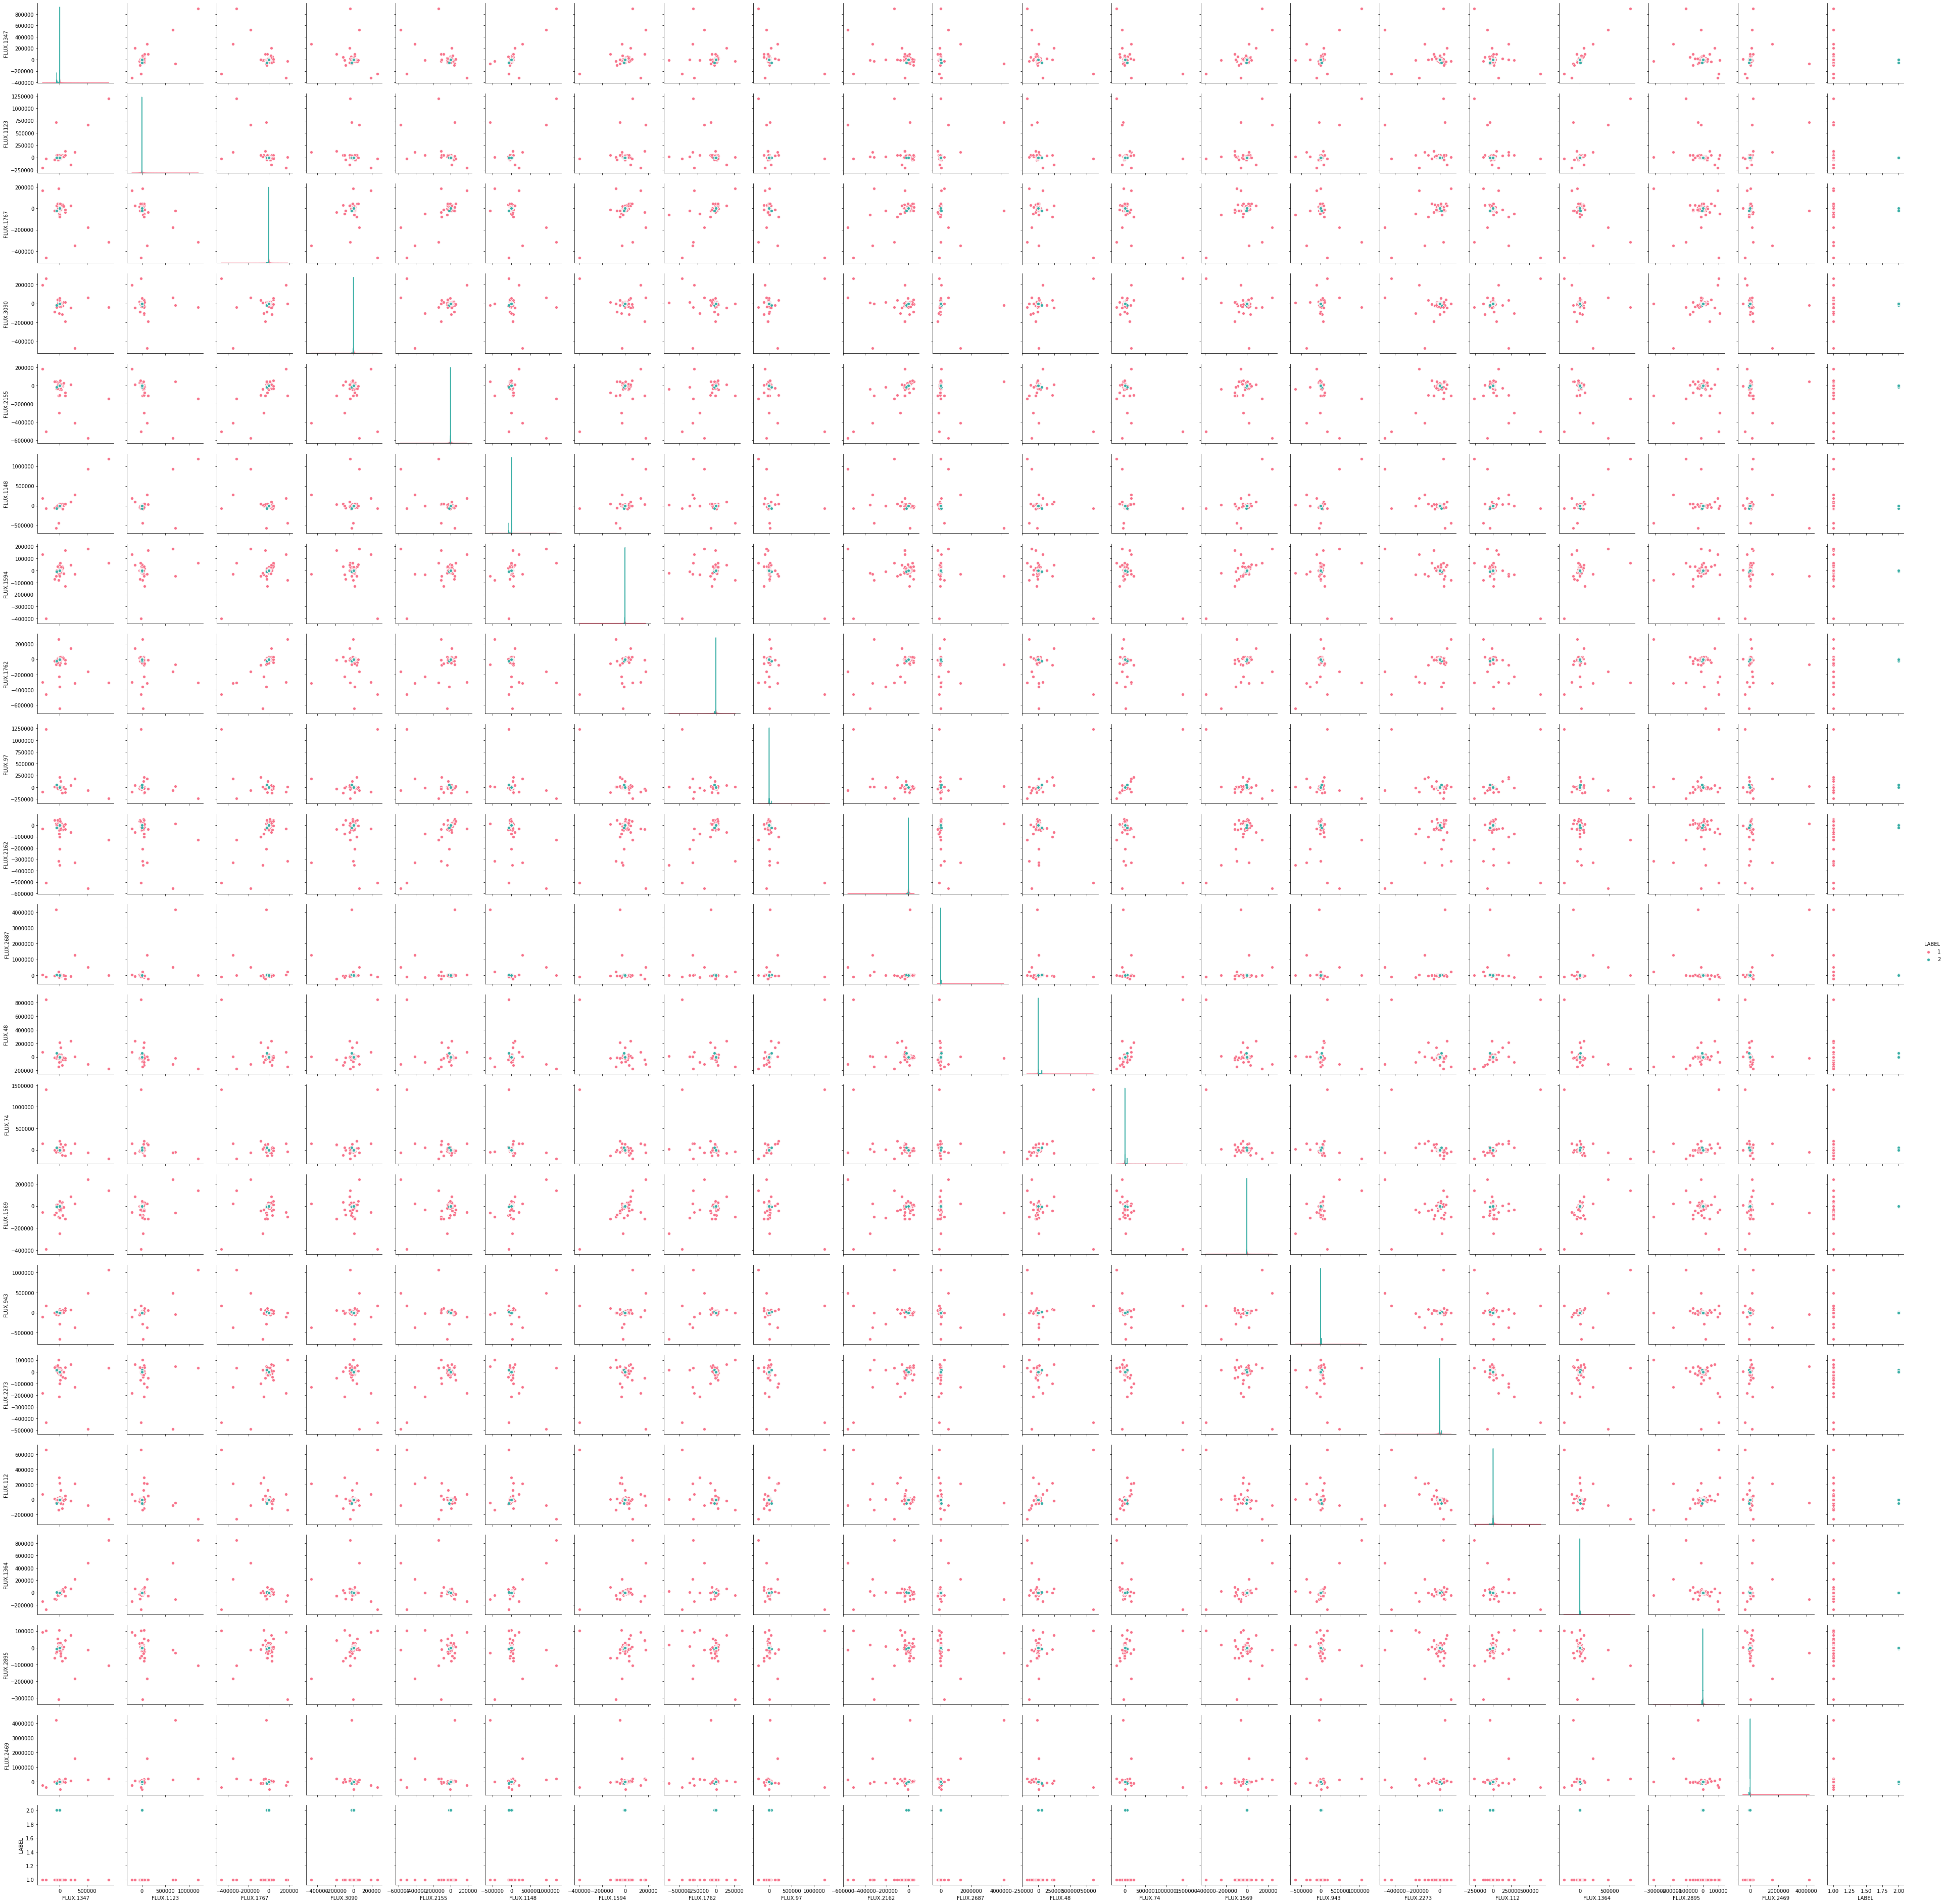

In [18]:
# Selecting a random selection of 20 the variables to show pairplot in train set

np.random.seed(123)

Train_col=list(train.columns)

Train_col.pop(0)

target=['LABEL']

train_col_rand=np.random.choice(Train_col,20)

Train2=train.loc[:,train_col_rand]
Train2[target]=train.loc[:,target]
print(Train2.shape)

#Pairplots for 20 random variables
plt.figure(figsize=(20,20))
sns.pairplot(data=Train2,hue='LABEL',palette='husl')

<font size="4" color='#03D3E8'>
    <b>3.7.2 Boxplots</b>         
</font> 

Outlier in y Fig FLUX.1347
Outlier in y Fig FLUX.1123
Outlier in y Fig FLUX.1767
Outlier in y Fig FLUX.3090
Outlier in y Fig FLUX.2155
Outlier in y Fig FLUX.1148
Outlier in y Fig FLUX.1594
Outlier in y Fig FLUX.1762
Outlier in y Fig FLUX.97
Outlier in y Fig FLUX.2162
Outlier in y Fig FLUX.2687
Outlier in y Fig FLUX.48
Outlier in y Fig FLUX.74
Outlier in y Fig FLUX.1569
Outlier in y Fig FLUX.943
Outlier in y Fig FLUX.2273
Outlier in y Fig FLUX.112
Outlier in y Fig FLUX.1364
Outlier in y Fig FLUX.2895
Outlier in y Fig FLUX.2469


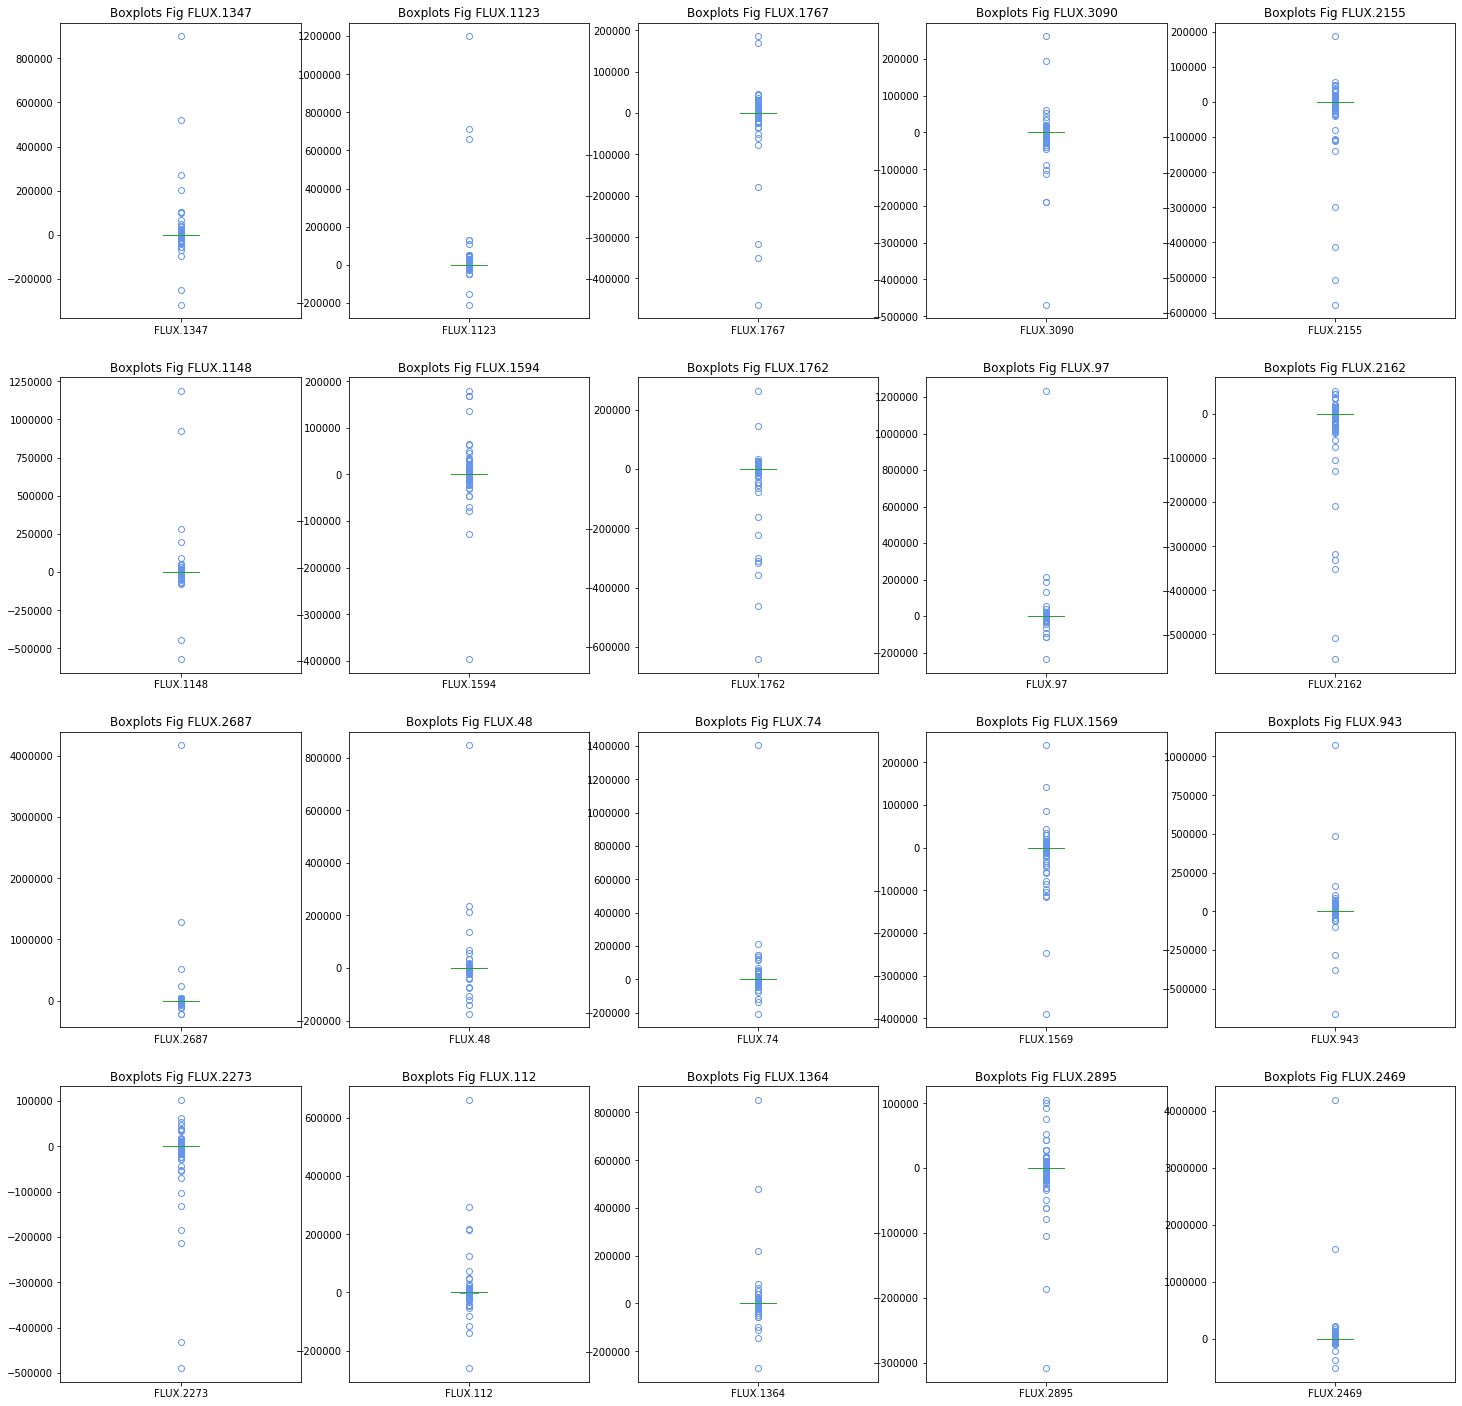

In [19]:
# Random selection of 20 the variables to show boxplot in train set
IQR_y=[]
LS_y=[]
LI_y=[]

fig_box,axes_box=plt.subplots(nrows=4,ncols=5,figsize=(25,25))

for i in range(0,len(train_col_rand)):      
    IQR_y.append(pd.DataFrame(train[train_col_rand[i]]).describe().loc['75%']-pd.DataFrame(train[train_col_rand[i]]).describe().loc['25%'])
    LS_y.append(pd.DataFrame(train[train_col_rand[i]]).describe().loc['75%']+1.5*IQR_y[i])
    LI_y.append(pd.DataFrame(train[train_col_rand[i]]).describe().loc['25%']-1.5*IQR_y[i])
    if any(LS_y[i] < pd.DataFrame(train[train_col_rand[i]])) or any(LI_y[i] > pd.DataFrame(train[train_col_rand[i]])):
        print('Outlier in y Fig '+str(train_col_rand[i]))
    else:
        print('No outlier in y Fig '+str(train_col_rand[i]))  
    ax_box=axes_box.flatten()
    ax_box[i].set_title('Boxplots Fig '+str(train_col_rand[i]))
    c='cornflowerblue'
    pd.DataFrame(train[train_col_rand[i]]).boxplot(ax=ax_box[i],grid=False,patch_artist=True,
                  boxprops=dict(facecolor=c, color=c),capprops=dict(color=c),whiskerprops=dict(color=c),flierprops=dict(color=c, markeredgecolor=c),
                 medianprops=dict(color=c))

<font size="5" color='#03D3E8'>
    <b>4. Pre-Processing</b>         
</font> 

<font size="4" color='#03D3E8'>
    <b>4.1 Preparing Training dataset</b>         
</font> 

In [23]:
X_train = train[features].copy()

In [24]:
X_train.head(3)

,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,FLUX.10,...,FLUX.3187,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196
0,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,-160.17,...,-16.51,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08
1,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,-73.38,...,12.53,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00
2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,484.39,...,-83.83,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02


In [25]:
y_train = train[target].copy()

In [26]:
y_train.head(3)

0    2
1    2
2    2
Name: LABEL, dtype: int64

In [27]:
X_test = test[features].copy()
X_test.head(3)

,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,FLUX.10,...,FLUX.3187,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196
0,119.88,100.21,86.46,48.68,46.12,39.39,18.57,6.98,6.63,-21.97,...,5.91,14.52,19.29,14.44,-1.62,13.33,45.50,31.93,35.78,269.43
1,5736.59,5699.98,5717.16,5692.73,5663.83,5631.16,5626.39,5569.47,5550.44,5458.80,...,-175.66,-581.91,-984.09,-1230.89,-1600.45,-1824.53,-2061.17,-2265.98,-2366.19,-2294.86
2,844.48,817.49,770.07,675.01,605.52,499.45,440.77,362.95,207.27,150.46,...,-19.73,17.82,-51.66,-48.29,-59.99,-82.10,-174.54,-95.23,-162.68,-36.79


In [28]:
y_test = test[target].copy()
y_test.head(3)

0    2
1    2
2    2
Name: LABEL, dtype: int64

In [29]:
labels_list=np.array(train['LABEL'])
len(labels_list)

5087

<font size="5" color='#03D3E8'>
    <b>5. Prediction Models and Prediction Analysis</b>         
</font> 

#### LGBMRegressor

In [30]:
# Use Sklearn to create Model and train model 

print('Start training...')
gbm = lgb.LGBMRegressor(objective='regression',num_leaves=20,learning_rate=0.05,n_estimators=20)
gbm.fit(X_train, y_train,eval_set=[(X_test, y_test)],eval_metric='l1',early_stopping_rounds=5)


Start training...
[1]	valid_0's l1: 0.0158363	valid_0's l2: 0.00864816
Training until validation scores don't improve for 5 rounds
[2]	valid_0's l1: 0.0158545	valid_0's l2: 0.00862168
[3]	valid_0's l1: 0.0158311	valid_0's l2: 0.00858273
[4]	valid_0's l1: 0.0158646	valid_0's l2: 0.00856454
[5]	valid_0's l1: 0.0158782	valid_0's l2: 0.0085459
[6]	valid_0's l1: 0.0159822	valid_0's l2: 0.00848153
[7]	valid_0's l1: 0.0159661	valid_0's l2: 0.00843816
[8]	valid_0's l1: 0.0159181	valid_0's l2: 0.0084078
Early stopping, best iteration is:
[3]	valid_0's l1: 0.0158311	valid_0's l2: 0.00858273


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.05, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=20, n_jobs=-1, num_leaves=20, objective='regression',
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [31]:
print('Start predicting...')
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration_)
print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)

Start predicting...
The rmse of prediction is: 0.0926430399628523


In [32]:
gbmModel = lgb.LGBMClassifier()
gbmModel.fit(X_train,y_train)
y_pred = gbmModel.predict(X_test)
print("Accuracy Score:",metrics.accuracy_score(y_test,y_pred))
print("ROC AUC:",metrics.roc_auc_score(y_test,y_pred))

Accuracy Score: 0.9912280701754386
ROC AUC: 0.5


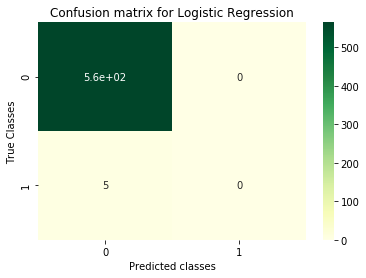

In [33]:
plt.title('Confusion matrix for Logistic Regression')
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap="YlGn")
plt.xlabel('Predicted classes')
plt.ylabel('True Classes')
plt.show()

In [34]:
# Use LGB.train()
# Convert the training data into LightGBM dataset formate 
# manually build python dictionary with lgb parameters 

lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

params = {
 'task': 'train',
 'boosting_type': 'gbdt',
 'objective': 'regression', 
 'metric': {'l2', 'auc'}, 
 'num_leaves': 31, 
 'learning_rate': 0.05, 
 'feature_fraction': 0.9, 
 'bagging_fraction': 0.8, 
 'bagging_freq': 5,
 'verbose': 1 
}

print('Start training...')

gbm = lgb.train(params,lgb_train,num_boost_round=50,valid_sets=lgb_eval,early_stopping_rounds=5)


Start training...
[1]	valid_0's auc: 1	valid_0's l2: 0.00864632
Training until validation scores don't improve for 5 rounds
[2]	valid_0's auc: 1	valid_0's l2: 0.00859966
[3]	valid_0's auc: 1	valid_0's l2: 0.00855962
[4]	valid_0's auc: 1	valid_0's l2: 0.0085213
[5]	valid_0's auc: 1	valid_0's l2: 0.00848934
[6]	valid_0's auc: 1	valid_0's l2: 0.00844651
Early stopping, best iteration is:
[1]	valid_0's auc: 1	valid_0's l2: 0.00864632


In [35]:
yy_pred = gbm.predict(X_test)

accuracy=accuracy_score(yy_pred.round(),y_test)

print('The rmse of prediction is:', mean_squared_error(y_test, yy_pred) ** 0.5)

print("Accuracy Score:",accuracy)
print("ROC AUC:",metrics.roc_auc_score(y_test,y_pred))

The rmse of prediction is: 0.09298560810734557
Accuracy Score: 0.9912280701754386
ROC AUC: 0.5


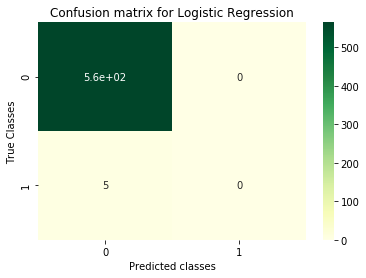

In [36]:

plt.title('Confusion matrix for Logistic Regression')
sns.heatmap(confusion_matrix(y_test, yy_pred.round()), annot=True, cmap="YlGn")
plt.xlabel('Predicted classes')
plt.ylabel('True Classes')
plt.show()


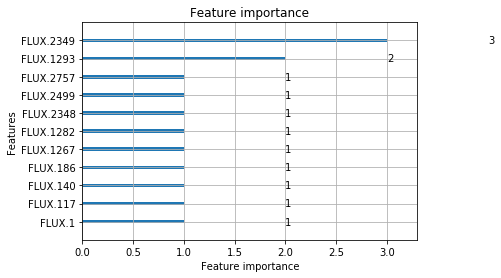

In [37]:
lgb.plot_importance(gbm)
plt.show()

In [ ]:
data_train = lgb.Dataset(X_train, y_train)
cv_results = lgb.cv(params, data_train, num_boost_round=50, nfold=5, stratified=False, shuffle=True, metrics='auc',early_stopping_rounds=50,seed=0)
print('best n_estimators:', len(cv_results['auc-mean']))
print('best cv score:', pd.Series(cv_results['auc-mean']).max())

#### Transformation, Logistic Regression, Gradient Boosting

In [ ]:
cont_vars = list(train.drop(['LABEL'],1).columns)

In [81]:
#NUMERICAL PIPELINE: scaling
num_scl_step = ('scale', MinMaxScaler())
num_steps = [num_scl_step]
num_pipe = Pipeline(num_steps)
num_transformers = [('num', num_pipe, cont_vars)]

In [83]:
ct = ColumnTransformer(transformers=num_transformers)
ct.fit(train[cont_vars])
X_train = ct.transform(train[cont_vars])
ct.fit(test[cont_vars])
X_test = ct.transform(test[cont_vars])
y_train = train['LABEL'].values
y_test = test['LABEL'].values

In [84]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(5087, 3197) (570, 3197) (5087,) (570,)


As you can see below the data is much easier to visualize with a more consistent scale between the features. this will also help us in our predictive models.

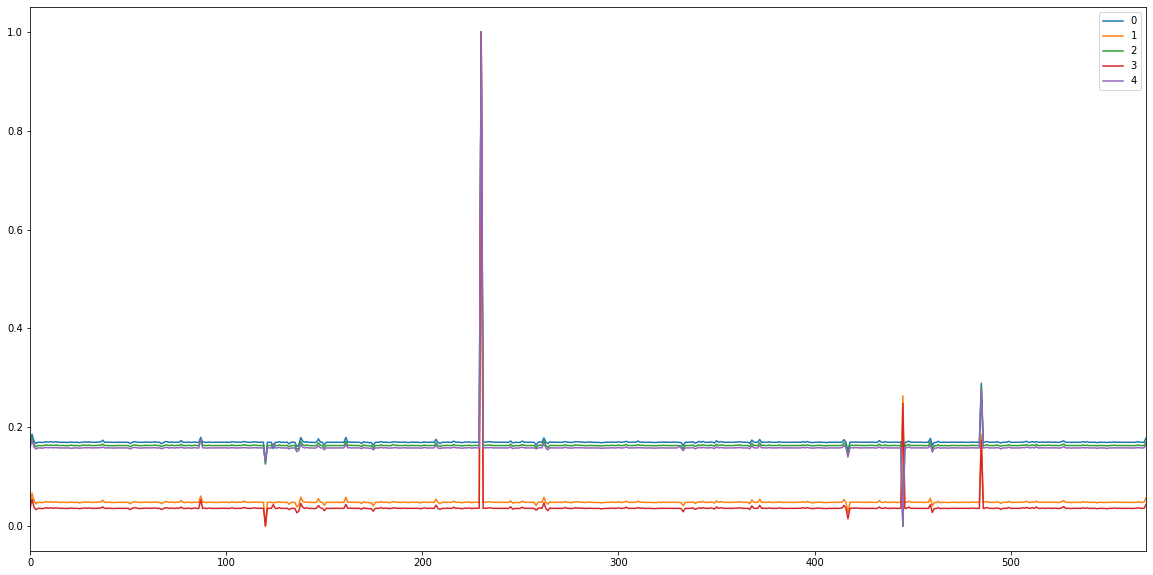

In [85]:
random = pd.DataFrame(data=X_test)
sample2  = random.iloc[:, 0:5]
sample2.plot(figsize=(20,10))

#### Principal Component Analysis
Below we use PCA to determine number of components to achieve 95% cumulative explained variation

In [86]:
pca = PCA(.95)

pca.fit(X_train)

print('Cumulative explained variation: {}'.format(np.sum(pca.explained_variance_ratio_)))

Cumulative explained variation: 0.9575563848002246


As you can see below 11 components explain 95% of the variance. 

we now use this to transform the data feature data for both the training and test set.

In [87]:
pca.n_components_

11

In [94]:
X_train_pca=pca.transform(X_train)
X_test_pca=pca.transform(X_test)

#### Logistic Regression Model

In [95]:
logisticRegr = LogisticRegression(solver='lbfgs')
logisticRegr.fit(X_train_pca,y_train)
y_pred1=logisticRegr.predict(X_test_pca)

Accuracy Score for Logistic Regression: 99.12 %
ROC AUC: 0.5
Precision Score: 0.9912280701754386
Recall Score: 1.0
F1 Score: 0.9955947136563876


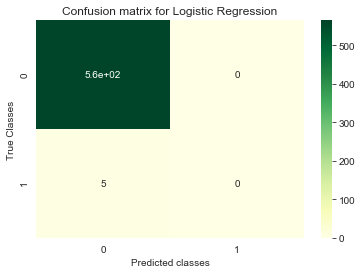

In [96]:
sns.set_style("whitegrid")

print('Accuracy Score for Logistic Regression:'\
      , round(accuracy_score(y_test, y_pred1)*100, 2), '%')
print('ROC AUC:'\
     ,roc_auc_score(y_test,y_pred1))
print('Precision Score:'\
     ,precision_score(y_test,y_pred1))
print('Recall Score:'\
     ,recall_score(y_test,y_pred1))
print('F1 Score:'\
     ,f1_score(y_test,y_pred1))
plt.title('Confusion matrix for Logistic Regression')
sns.heatmap(confusion_matrix(y_test, y_pred1), annot=True, cmap="YlGn")
plt.xlabel('Predicted classes')
plt.ylabel('True Classes')
plt.show()

#### Gradient Boosting Regression Model

In [97]:
gbes = ensemble.GradientBoostingRegressor(n_estimators=100)
gbes.fit(X_train, y_train)
mean_squared_error(gbes.predict(X_test), y_test)

0.012366658144702706

In [98]:
y_pred2 = gbes.predict(X_test).round()

Accuracy Score for Logistic Regression: 98.95 %
ROC AUC: 0.49911504424778763
Precision Score: 0.9912126537785588
Recall Score: 0.9982300884955753
F1 Score: 0.9947089947089948


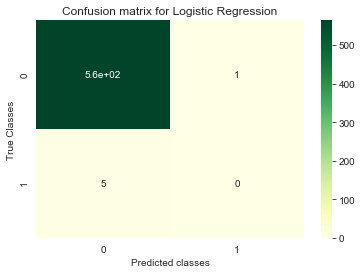

In [99]:
print('Accuracy Score for Logistic Regression:'\
      , round(accuracy_score(y_test, y_pred2)*100, 2), '%')
print('ROC AUC:'\
     ,roc_auc_score(y_test,y_pred2))
print('Precision Score:'\
     ,precision_score(y_test,y_pred2))
print('Recall Score:'\
     ,recall_score(y_test,y_pred2))
print('F1 Score:'\
     ,f1_score(y_test,y_pred2))
plt.title('Confusion matrix for Logistic Regression')
sns.heatmap(confusion_matrix(y_test, y_pred2), annot=True, cmap="YlGn")
plt.xlabel('Predicted classes')
plt.ylabel('True Classes')
plt.show()

### Additional Analysia and Prediction Models

<font size="4" color='#03D3E8'>
    <b>Undersampling</b>         
</font>

Since the data is high unbalanced, it will be applied undersampling over the class 1

In [100]:
undersampling=pd.DataFrame(train['LABEL'].value_counts())
undersampling['% Class']=(train['LABEL'].value_counts(normalize=True))*100
undersampling['% Class Test']=(test['LABEL'].value_counts(normalize=True))*100

In [101]:
undersampling

,LABEL,% Class,% Class Test
1,5050,99.272656,99.122807
2,37,0.727344,0.877193


In [102]:
undersampling['LABEL'][2]/undersampling['LABEL'][1]

0.007326732673267326

In [103]:
from math import sqrt

def CCMUT(X,f):
    # 1. finding cluster centroid....
    cluster_centroid = np.sum(X,axis=0)/X.shape[0]
    # 2. finding Euclidean Distance from cluster centroid to samples
    euclidean = [None]*X.shape[0]
    for i in range(0,X.shape[0]):
        euclidean[i] = sqrt(sum((cluster_centroid-X.iloc[i])**2))
    # 3. tracking indices of samples in descending order of distance
    indices = list(reversed(sorted(range(len(euclidean)), 
    key = lambda j: euclidean[j])))
    # 4. removing the instances or under-sampling order-wise....
    X=np.array(X)
    X_f = np.delete(X, indices[:int(f/100*X.shape[0])], axis=0)
    # 5. returning the under-sampled Majority Sample Matrix
    return X_f

In [104]:
Train_under=train[train['LABEL']==1]
Test_under=test[test['LABEL']==1]

In [105]:
print(Train_under.shape)
print(Test_under.shape)

(5050, 3198)
(565, 3198)


In [107]:
X_f2=pd.DataFrame(CCMUT(Train_under,20),columns=list(train.columns))
X_f3=pd.DataFrame(CCMUT(Test_under,20),columns=list(test.columns))

In [108]:
print(X_f2.shape)
print(X_f3.shape)

(4040, 3198)
(452, 3198)


In [109]:
Train2=pd.concat([train[train['LABEL']==2],X_f2],axis=0)
Test2=pd.concat([test[test['LABEL']==2],X_f3],axis=0)

In [110]:
print(Train2.shape)
print(Test2.shape)

(4077, 3198)
(457, 3198)


In [111]:
Train2.head()

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2.0,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,2.0,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,2.0,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,2.0,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,2.0,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54


<font size="4" color='#03D3E8'>
    <b>Pipeline</b>         
</font>

It can be seen extreme values with minimum and maximum, it will be normalized the data set using MinMax scaler and passes them using pipeline

In [112]:
variables=list(Train2.columns)
variables.remove('LABEL')

scale_step=('scale',MinMaxScaler())
num_pipe=Pipeline([scale_step])
num_trans=[('num',num_pipe, variables)]

col_trans=ColumnTransformer(transformers=num_trans)
col_trans.fit(Train2[variables])
X_Train=col_trans.transform(Train2[variables])
col_trans.fit(Test2[variables])
X_Test=col_trans.transform(Test2[variables])

In [113]:
X_Train

array([[0.01261927, 0.01419955, 0.01873817, ..., 0.26992834, 0.12744132,
        0.09083501],
       [0.01174924, 0.01330399, 0.01798286, ..., 0.26565206, 0.12785104,
        0.09244394],
       [0.01549551, 0.01764132, 0.02347933, ..., 0.26290003, 0.12462358,
        0.08928939],
       ...,
       [0.01379614, 0.01567786, 0.02105895, ..., 0.27202913, 0.13021741,
        0.09405368],
       [0.01202913, 0.01357744, 0.01851352, ..., 0.26401734, 0.12701022,
        0.09183575],
       [0.01412317, 0.01589375, 0.02136083, ..., 0.26384849, 0.12672207,
        0.0926574 ]])

In [114]:
X_Test

array([[0.14413212, 0.14209879, 0.14209054, ..., 0.90932735, 0.81717075,
        0.87115308],
       [1.        , 1.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       [0.25454584, 0.25198819, 0.2462473 , ..., 0.83419522, 0.71958662,
        0.8598746 ],
       ...,
       [0.14787911, 0.12982417, 0.1513862 , ..., 0.83821191, 0.66228597,
        0.76261907],
       [0.12581008, 0.12750621, 0.12986952, ..., 0.89376789, 0.72781157,
        0.84244271],
       [0.11763496, 0.11998548, 0.12263533, ..., 0.89785272, 0.73591862,
        0.85490774]])

In [115]:
Y_Train=np.array(Train2['LABEL'])
Y_Test=np.array(Test2['LABEL'])

print(len(Y_Train))
print(len(Y_Test))

4077
457


In [116]:
s=pd.DataFrame(Train2['LABEL'].value_counts())
s['% Class']=(Train2['LABEL'].value_counts(normalize=True))*100
s['% Class Test2']=(Test2['LABEL'].value_counts(normalize=True))*100

In [117]:
s

,LABEL,% Class,% Class Test2
1.0,4040,99.09247,98.905908
2.0,37,0.90753,1.094092


<font size="4" color='#03D3E8'>
    <b>Dimension Reduction </b>        
</font>

It'll be used PCA to reduce dimension. Let's see how many components accumulates at least the 95% explained variance ratio

In [ ]:
np.random.seed(123)

pca=PCA()

pca.fit(X_Train)

cum_sum=np.cumsum(pca.explained_variance_ratio_)

dim= np.argmax(cum_sum>=0.95)+1

print('Number of components that explained 95% variance ratio',dim)

In [ ]:
# --- Adjusting PCA to 27 components
pca_adj=PCA(n_components=27)
X_Train_PCA=pca_adj.fit_transform(X_Train)
X_Test_PCA=pca_adj.fit_transform(X_Test)
cum_sum_X_Train=np.cumsum(pca_adj.explained_variance_ratio_)

print(len(X_Train_PCA))
print(len(X_Test_PCA))

<font size="4" color='#03D3E8'>
    <b>Random Forest with Grid Search</b>         
</font>

It will be tested with grid search and it will be compared with randomized_searchcv to define the best parameters

In [29]:
# Know local directory
#os.getcwd()
# Changing local directory
# os.chdir('D:\mis documentos\Data Science Certificate\Module 4 - Machine Learning\Group Assignment')
#os.chdir('C:/Users/m_leo/Documents/Mariuxi/A_Mariuxi/Data Science 4 Machine Learning/Project')

njobs=6
random_state=123

#Grid search #2
# param_randf={
# 'n_estimators':[int(x) for x in np.linspace(4,100, num=20)],
# 'criterion':['gini','entropy'],    
# 'min_samples_split':[x for x in np.linspace(0.0001, 0.001, num = 5)],
# 'min_impurity_decrease': [x for x in np.linspace(0.00001,0.00005, num = 5)],
# 'max_depth': [int(x) for x in np.linspace(2,10, num = 8)],
# 'random_state':[random_state] 
# }

# Grid search #3
# param_randf={
# 'n_estimators':[int(x) for x in np.linspace(50, 150, num = 5)],
# 'criterion':['gini','entropy'],    
# 'min_samples_split':[x for x in np.linspace(0.01, 0.05, num = 5)],
# 'min_impurity_decrease': [x for x in np.linspace(8.333333333333334e-06,0.00005, num = 5)],
# 'max_depth': [int(x) for x in np.linspace(10,35, num = 8)],
# 'max_features':['sqrt','log2',None],
# 'random_state':[random_state] 
# }

# Grid search #4
# param_randf={
# 'n_estimators':[int(x) for x in np.linspace(50, 100, num = 5)],
# 'criterion':['gini','entropy'],    
# 'min_samples_split':[x for x in np.linspace(0.01, 0.02, num = 2)],
# # 'min_impurity_decrease': [x for x in np.linspace(8.333333333333334e-07,8.333333333333334e-06, num = 2)],
# 'max_depth': [int(x) for x in np.linspace(2,10, num = 8)],
# 'max_features':['sqrt','log2',None],
# 'random_state':[random_state],
# 'class_weight'={2:.01,1:.99}    
# }

# #Grid search #5
# param_randf={
# 'n_estimators':[int(x) for x in np.linspace(50, 300, num = 10)],
# 'criterion':['gini','entropy'],    
# 'min_samples_split':[x for x in np.linspace(0.01, 0.02, num = 2)],
# # 'min_impurity_decrease': [x for x in np.linspace(8.333333333333334e-07,8.333333333333334e-06, num = 2)],
# 'max_depth': [int(x) for x in np.linspace(2,100, num = 20)],
# 'max_features':['sqrt','log2',None],
# 'random_state':[random_state]  
# }

# Grid search #6
param_randf={
'n_estimators':[int(x) for x in np.linspace(50, 300, num = 10)],
'criterion':['gini','entropy'],    
'min_samples_split':[x for x in np.linspace(0.01, 0.02, num = 2)],
# 'min_impurity_decrease': [x for x in np.linspace(8.333333333333334e-07,8.333333333333334e-06, num = 2)],
'max_depth': [int(x) for x in np.linspace(2,100, num = 20)],
'max_features':['sqrt','log2',None],
'random_state':[random_state]  
}

start_rf_grid= dt.datetime.now()

rf_grid=GridSearchCV(estimator=RandomForestClassifier(class_weight={2:.01,1:.99} ), param_grid=param_randf,scoring='precision',n_jobs=njobs,cv=5)
rf_grid.fit(X_Train_PCA,Y_Train)

end_rf_grid= dt.datetime.now()

#Saving model - with Grid Search
pickle.dump(rf_grid,open("random_forest_grid_search6.sav", "wb"))

#Loading model - with Grid Search
# rf_grid=pickle.load(open('random_forest_grid_search6.sav','rb'))


total_time_rf_grid=end_rf_grid-start_rf_grid


print('total_time_Grid_Search',total_time_rf_grid)  
print('best_estimator',rf_grid.best_estimator_)
print('best_score',rf_grid.best_score_)
print('best_params',rf_grid.best_params_)

Y_pred_rf_grid=rf_grid.predict(X_Test_PCA)


KS = ks_2samp(Y_pred_rf_grid[Y_Test==2], Y_pred_rf_grid[Y_Test!=2]).statistic
Gini=2*roc_auc_score(Y_Test,Y_pred_rf_grid)-1


summary_list=[]

summary_list.append(['Random Forest with Grid Search',roc_auc_score(Y_Test,Y_pred_rf_grid),accuracy_score(Y_Test,Y_pred_rf_grid),precision_score(Y_Test,Y_pred_rf_grid,pos_label=2),recall_score(Y_Test,Y_pred_rf_grid,pos_label=2),f1_score(Y_Test,Y_pred_rf_grid),KS,Gini])


pd.DataFrame(summary_list,columns=['Model Name','ROC AUC','Accuracy','Precision','Recall','F1','KS','Gini'])



total_time_Grid_Search 14:03:31.798756
best_estimator RandomForestClassifier(bootstrap=True, class_weight={2: 0.01, 1: 0.99},
            criterion='gini', max_depth=7, max_features=None,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=0.01, min_weight_fraction_leaf=0.0,
            n_estimators=77, n_jobs=None, oob_score=False,
            random_state=123, verbose=0, warm_start=False)
best_score 0.9921426506879778
best_params {'criterion': 'gini', 'max_depth': 7, 'max_features': None, 'min_samples_split': 0.01, 'n_estimators': 77, 'random_state': 123}


,Model Name,ROC AUC,Accuracy,Precision,Recall,F1,KS,Gini
0,Random Forest with Grid Search,0.782743,0.765864,0.036364,0.8,0.866083,0.565487,0.565487


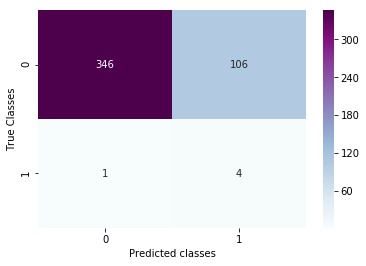

In [30]:
ax=sns.heatmap(confusion_matrix(Y_Test,Y_pred_rf_grid),annot=True,cmap="BuPu",fmt='d')
plt.xlabel('Predicted classes')
plt.ylabel('True Classes')
plt.show()

Text(0.5, 1.0, 'ROC Curve - Random Forest - Grid Search')

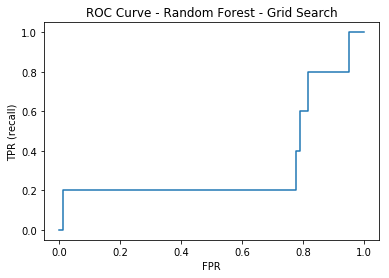

In [31]:
# ROC Curves with Random Forest - Grid Search

y_scores_rf=rf_grid.predict_proba(X_Test_PCA)  

fpr, tpr, thresholds = roc_curve(Y_Test,y_scores_rf[:,0],pos_label=2)
plt.plot(fpr, tpr, label="ROC Curve Random Forest")

plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
plt.title("ROC Curve - Random Forest - Grid Search")


<font size="4" color='#03D3E8'>
    <b>Random Forest with Randomized Search CV</b>         
</font>

It will be tested with randomized search and it will be compared with grid_search to define the best parameters

In [32]:
param_randf={
'n_estimators':[int(x) for x in np.linspace(50, 300, num = 10)],
'criterion':['gini','entropy'],    
'min_samples_split':[x for x in np.linspace(0.01, 0.02, num = 2)],
# 'min_impurity_decrease': [x for x in np.linspace(8.333333333333334e-07,8.333333333333334e-06, num = 2)],
'max_depth': [int(x) for x in np.linspace(2,100, num = 20)],
'max_features':['sqrt','log2',None],
'random_state':[random_state]  
}

start_rf_rscv= dt.datetime.now()

rf_rscv=RandomizedSearchCV(estimator=RandomForestClassifier(class_weight={2:.01,1:.99}), param_distributions=param_randf,scoring='precision',n_jobs=njobs,cv=5)
rf_rscv.fit(X_Train_PCA,Y_Train)

end_rf_rscv= dt.datetime.now()

#Saving model - with Grid Search
pickle.dump(rf_rscv,open("random_forest_rscv2.sav", "wb"))

# Loading model - with Grid Search
# rf_rscv=pickle.load(open('random_forest_rscv2.sav','rb'))


total_time_rf_rscv=end_rf_rscv-start_rf_rscv


print('total_time_rscv_Search',total_time_rf_rscv)  
print('best_estimator',rf_rscv.best_estimator_)
print('best_score',rf_rscv.best_score_)
print('best_params',rf_rscv.best_params_)

Y_pred_rf_rscv=rf_rscv.predict(X_Test_PCA)

KS = ks_2samp(Y_pred_rf_rscv[Y_Test==2], Y_pred_rf_rscv[Y_Test!=2]).statistic
Gini=2*roc_auc_score(Y_Test,Y_pred_rf_rscv)-1

summary_list.append(['Random Forest with RandomizedSearchCV',roc_auc_score(Y_Test,Y_pred_rf_rscv),accuracy_score(Y_Test,Y_pred_rf_rscv),precision_score(Y_Test,Y_pred_rf_rscv,pos_label=2),recall_score(Y_Test,Y_pred_rf_rscv,pos_label=2),f1_score(Y_Test,Y_pred_rf_rscv),KS,Gini])


pd.DataFrame(summary_list,columns=['Model Name','ROC AUC','Accuracy','Precision','Recall','F1','KS','Gini'])

total_time_rscv_Search 0:01:18.121039
best_estimator RandomForestClassifier(bootstrap=True, class_weight={2: 0.01, 1: 0.99},
            criterion='gini', max_depth=100, max_features=None,
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=0.02, min_weight_fraction_leaf=0.0,
            n_estimators=133, n_jobs=None, oob_score=False,
            random_state=123, verbose=0, warm_start=False)
best_score 0.9921426506879778
best_params {'random_state': 123, 'n_estimators': 133, 'min_samples_split': 0.02, 'max_features': None, 'max_depth': 100, 'criterion': 'gini'}


,Model Name,ROC AUC,Accuracy,Precision,Recall,F1,KS,Gini
0,Random Forest with Grid Search,0.782743,0.765864,0.036364,0.8,0.866083,0.565487,0.565487
1,Random Forest with RandomizedSearchCV,0.786062,0.772429,0.037383,0.8,0.870324,0.572124,0.572124


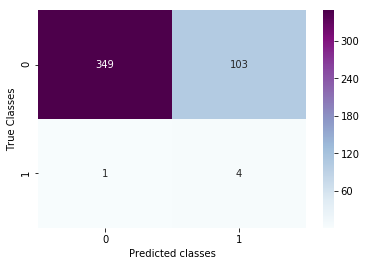

In [34]:
ax=sns.heatmap(confusion_matrix(Y_Test,Y_pred_rf_rscv),annot=True,cmap="BuPu",fmt='d')
plt.xlabel('Predicted classes')
plt.ylabel('True Classes')
plt.show()

Text(0.5, 1.0, 'ROC Curve - Random Forest - Randomized Search CV')

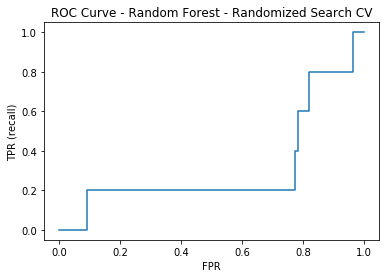

In [35]:
#ROC Curves with Random Forest - Randomized Search CV

y_scores_rscv=rf_rscv.predict_proba(X_Test_PCA)  

fpr, tpr, thresholds = roc_curve(Y_Test,y_scores_rscv[:,0],pos_label=2)
plt.plot(fpr, tpr, label="ROC Curve Random Forest")

plt.xlabel("FPR")
plt.ylabel("TPR (recall)")
plt.title("ROC Curve - Random Forest - Randomized Search CV")


In [36]:
X=np.concatenate((X_Train,X_Test),axis=0)
y=np.concatenate((Y_Train,Y_Test),axis=0)

print(len(X))
print(len(y))

4534
4534


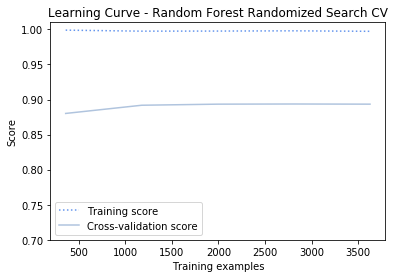

In [37]:
#---------------------------------------------------------------------------------------------------
# Plot Learning Curves
#---------------------------------------------------------------------------------------------------

#------- Random Forest - Randomized Search CV ----------

#Choosing best parameters after Randomized Search CV


estimator=RandomForestClassifier(max_depth=79,n_estimators=105,min_samples_split=0.01,max_features=None,criterion='gini',random_state=random_state)

train_sizes_rf, train_scores_rf, test_scores_rf = learning_curve(estimator=estimator, X=X, y=y, cv=5, n_jobs=njobs,random_state=[random_state])

train_sizes_rf.shape
train_scores_rf.shape
test_scores_rf.shape

train_scores_rf_mean=np.mean(train_scores_rf,axis=1)
test_scores_rf_mean=np.mean(test_scores_rf,axis=1)

plt.plot(train_sizes_rf,train_scores_rf_mean,linestyle=':',color='cornflowerblue',label='Training score')
plt.plot(train_sizes_rf,test_scores_rf_mean,color='lightsteelblue',label='Cross-validation score')
plt.ylim((0.7, 1.01))
plt.title('Learning Curve - Random Forest Randomized Search CV')
plt.ylabel('Score')
plt.xlabel('Training examples')
plt.legend()
plt.show()


According with the results provided, the randomized search cv obtained the best results on ROC-AUC, Accuracy, Recall, KS and Gini also the time processing was better with run time 42 seg vs. 2h 15 min run time for grid search. Even with a high unbalanced test, it could be detected 4 exoplanet from 5 available in the test set. It is remarkable that the model not only predict 1 - normal stars is capable to detect exoplanets as well, this is the challenge when are handled unbalanced classes in a predictive model that is a common scenario in realtime datasets.

#### KNeignboors Classifier after PCA Reduction

In [67]:
from sklearn.neighbors import KNeighborsClassifier
import time

begin_time=time.time()

KNN_PCA = KNeighborsClassifier()

param_KNN = {'n_neighbors':[3,5,10,20],
              'weights':['uniform','distance'],
              'metric':['euclidean', 'manhattan'],
              'n_jobs':[-1]}

KNN_PCA_grid = GridSearchCV(estimator=KNN_PCA, param_grid=param_KNN, scoring='neg_mean_squared_error',cv= 5)
KNN_PCA_grid.fit(X_Train_PCA,Y_Train)

print ('The time the KNeighbors Classifier:','%sseconds' %(time.time()-begin_time))
print('\n''The best params KNeighbors Classifier:',KNN_PCA_grid.best_params_)
print('\n''The best estimators KNeighbors Classifier:',KNN_PCA_grid.best_estimator_)

The time the KNeighbors Classifier: 33.479323863983154seconds

The best params KNeighbors Classifier: {'metric': 'euclidean', 'n_jobs': -1, 'n_neighbors': 3, 'weights': 'uniform'}

The best estimators KNeighbors Classifier: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
           metric_params=None, n_jobs=-1, n_neighbors=3, p=2,
           weights='uniform')


In [68]:
# Functions:

def rmse(a, b):
    return np.sqrt(np.mean((a-b)**2))
pd.options.display.max_columns = None
# to make this notebook's output identical at every run
np.random.seed(123)


def display_results(model, X, y):
    print("RMSE:", rmse(model.predict(X), y))
    print("Predicted 1-5:", model.predict(X_Test_PCA[0:5]))
    print("Actual 1-5:", X_Test_PCA[0:5, 0])
    
    
def display_scores(scores):
    print("Scores:", np.sqrt(-scores))
    print("Mean:", np.sqrt(-scores).mean())
    print("Standard deviation:", np.sqrt(-scores).std())

In [69]:
Final_model_KNN_PCA = KNN_PCA_grid.best_estimator_
display_results(Final_model_KNN_PCA, X_Test_PCA, Y_Test)

RMSE: 0.19287074616560446
Predicted 1-5: [1. 2. 1. 1. 1.]
Actual 1-5: [-2.26178863e-02  3.97605283e+01 -3.08005554e-01 -3.58301898e-01
 -2.66391026e-01]


In [70]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(Final_model_KNN_PCA, X_Test_PCA, Y_Test, cv=5, scoring='neg_mean_squared_error')
display_scores(scores)

Scores: [0.10425721 0.10425721 0.10482848 0.10482848 0.10482848]
Mean: 0.10459997301473005
Standard deviation: 0.0002798672557846326


In [71]:
Y_pred_KNN_PCA=Final_model_KNN_PCA.predict(X_Test_PCA)

In [72]:
print('Accuracy KNeighbors Classifier_PCA:', accuracy_score(Y_Test,Y_pred_KNN_PCA))
print('ROC KNeighbors Classifier_PCA:', roc_auc_score(Y_Test,Y_pred_KNN_PCA))
print('Precision KNeighbors Classifier_PCA:', precision_score(Y_Test,Y_pred_KNN_PCA))
print('Recall KNeighbors Classifier_PCA:', recall_score(Y_Test,Y_pred_KNN_PCA))
print('f1 KNeighbors Classifier_PCA:', f1_score(Y_Test,Y_pred_KNN_PCA))

Accuracy KNeighbors Classifier_PCA: 0.962800875273523
ROC KNeighbors Classifier_PCA: 0.5856194690265486
Precision KNeighbors Classifier_PCA: 0.9909706546275395
Recall KNeighbors Classifier_PCA: 0.9712389380530974
f1 KNeighbors Classifier_PCA: 0.9810055865921787


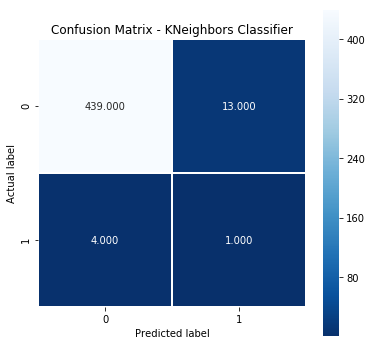

In [73]:
from sklearn import metrics

cm = metrics.confusion_matrix(Y_Test, Y_pred_KNN_PCA)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title("Confusion Matrix - KNeighbors Classifier");

One way to evaluate model performance is through the Confusion Matrix, in this case with the KNN Classifier the results are: 

The first row of the matrix considers the non-exoplanet-stars (label with 0):
439 were correctly classified as label 0.
13 were wrongly classified as label 0.
If we analyze with respect to the total of label 0 (452 non-exoplanet-stars): 97.12% were classified correctly and 2.88% incorrect.

The second row of the matrix considers confirmed exoplanet-stars (label with 1):
4 were wrongly classified as label 1.
1 was correctly classified as label 1
If we analyze with respect to the total of label 1 (5 non-exoplanet-stars): 20% were classified correctly and 80% incorrect.

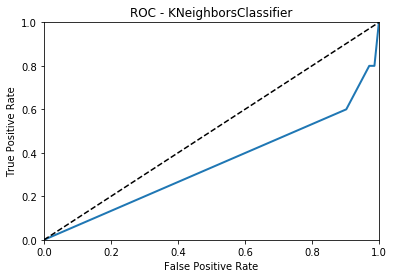

In [74]:
from sklearn.metrics import roc_curve

Y_scores_KNN=KNN_PCA_grid.predict_proba(X_Test_PCA)  

fpr, tpr, thresholds= roc_curve (Y_Test, Y_scores_KNN[:,0], pos_label=2)

def plot_roc_curve (fpr,tpr,label=None):
    plt.plot(fpr,tpr,linewidth=2, label=label)
    plt.plot([0,1],[0,1],'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title("ROC - KNeighborsClassifier")
plot_roc_curve(fpr,tpr)
plt.show()

The Receiver Operating Characteristic (ROC Curve) is another common tool used with binary classifiers. In the graph the dotted line represents the ROC curve of a purely random classifier and the blue line represents the ROC KNeighbors Classifier.

For a classifier to be considered good it must remain as far away as possible that the dote line (toward the top-left corner) which in the case of the KNN is not met.
Furthermore, the measurement of the area under the curve, in a perfect classifier, must be close to 1 and in the KNN it is 0.5856194690265486.

In [75]:
# Learning Curves

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.2)
    train_errors, validation_errors=[],[]
    for m in range (1, len(X_train)):
        model.fit(X_train[:m],np.ravel(y_train[:m]))
        y_train_predict=model.predict(X_train[:m])
        y_validation_predict=model.predict(X_validation)
        train_errors.append(mean_squared_error(y_train_predict, y_train[:m]))
        validation_errors.append(mean_squared_error(y_validation_predict,y_validation))
    ax = plt.subplot(111)
    ax.plot(np.sqrt(train_errors),'r-+',linewidth=2, label='training set')
    ax.plot(np.sqrt(validation_errors), 'b-', linewidth=3, label='validation set')
    ax.legend()
    plt.xlabel('Training set size')
    plt.ylabel('RMSE')

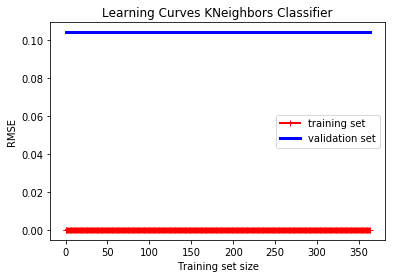

In [76]:
# Learning Curves KNeighborsClassifier

KNN_Model= KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',metric_params=None, n_jobs=-1, n_neighbors=1, p=2,
           weights='uniform')
plot_learning_curves(KNN_Model,X_Test_PCA,Y_Test)
plt.title('Learning Curves KNeighbors Classifier');

Training set: The model fits perfectly in all instances, the line is always in zero.

Validation set: The model starts with an error of 0.10 and remains constant with the same error during all the validation.

#### Decision Tree Classifier after PCA Reduction 

Additional model to the KNN that I chose in order to have another model to compare results.

In [77]:
from sklearn.tree import DecisionTreeClassifier

begin_time=time.time()

dtree_clf_PCA = DecisionTreeClassifier(random_state=123)

param_grid = {
    'criterion': ['gini','entropy'],
    'max_depth':[4,5,6,7,8,9,10,11,12,15,20]
}

dtree_clf_PCA_grid = GridSearchCV(estimator=dtree_clf_PCA, param_grid=param_grid,scoring='neg_mean_squared_error',cv=5)

dtree_clf_PCA_grid.fit(X_Train_PCA,Y_Train)

print ('The time the Decision Tree Classifier:','%sseconds' %(time.time()-begin_time))
print('\n''The best params Decision Tree Classifier:',dtree_clf_PCA_grid.best_params_)
print('\n''The best estimators Decision Tree Classifier:',dtree_clf_PCA_grid.best_estimator_)

The time the Decision Tree Classifier: 17.34139919281006seconds

The best params Decision Tree Classifier: {'criterion': 'gini', 'max_depth': 7}

The best estimators Decision Tree Classifier: DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=123,
            splitter='best')


In [78]:
Final_model_dtree_clf_PCA = dtree_clf_PCA_grid.best_estimator_
display_results(Final_model_dtree_clf_PCA, X_Test_PCA, Y_Test)

RMSE: 0.7883173227279167
Predicted 1-5: [1. 2. 1. 2. 2.]
Actual 1-5: [-2.26178863e-02  3.97605283e+01 -3.08005554e-01 -3.58301898e-01
 -2.66391026e-01]


In [79]:
scores = cross_val_score(Final_model_dtree_clf_PCA, X_Test_PCA, Y_Test, cv=5, scoring='neg_mean_squared_error')
display_scores(scores)

Scores: [0.14744196 0.20851441 0.14824986 0.20965697 0.18156826]
Mean: 0.1790862921378433
Standard deviation: 0.027418935234767766


In [81]:
Y_pred_dtree_clf_PCA=Final_model_dtree_clf_PCA.predict(X_Test_PCA)

In [82]:
print('Accuracy Decision Tree Classifier_PCA:', accuracy_score(Y_Test,Y_pred_dtree_clf_PCA))
print('ROC Decision Tree Classifier_PCA:', roc_auc_score(Y_Test,Y_pred_dtree_clf_PCA))
print('Precision Decision Tree Classifier_PCA:', precision_score(Y_Test,Y_pred_dtree_clf_PCA))
print('Recall Decision Tree Classifier_PCA:', recall_score(Y_Test,Y_pred_dtree_clf_PCA))
print('f1 Decision Tree Classifier_PCA:', f1_score(Y_Test,Y_pred_dtree_clf_PCA))

Accuracy Decision Tree Classifier_PCA: 0.3785557986870897
ROC Decision Tree Classifier_PCA: 0.48805309734513275
Precision Decision Tree Classifier_PCA: 0.9883720930232558
Recall Decision Tree Classifier_PCA: 0.37610619469026546
f1 Decision Tree Classifier_PCA: 0.5448717948717948


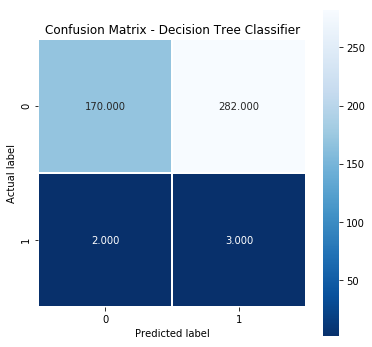

In [83]:
from sklearn import metrics

cm = metrics.confusion_matrix(Y_Test, Y_pred_dtree_clf_PCA)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
plt.title("Confusion Matrix - Decision Tree Classifier");

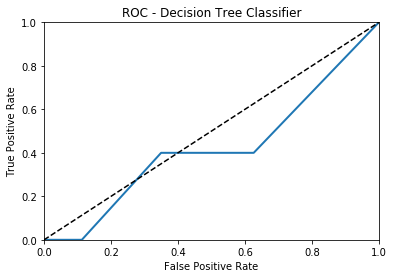

In [86]:
from sklearn.metrics import roc_curve

Y_scores_dtree_clf_PCA=dtree_clf_PCA_grid.predict_proba(X_Test_PCA)  

fpr, tpr, thresholds= roc_curve (Y_Test, Y_scores_dtree_clf_PCA[:,0], pos_label=2)

def plot_roc_curve (fpr,tpr,label=None):
    plt.plot(fpr,tpr,linewidth=2, label=label)
    plt.plot([0,1],[0,1],'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title("ROC - Decision Tree Classifier")
plot_roc_curve(fpr,tpr)
plt.show()

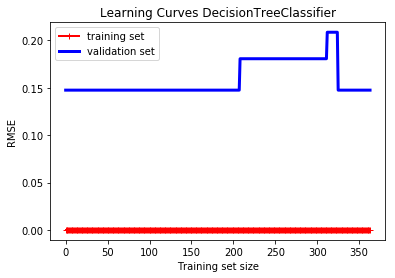

In [87]:
# Learning Curves KNeighborsClassifier

DecisionTreeClassifier_Model= DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
            max_features=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, presort=False, random_state=123,
            splitter='best')

plot_learning_curves(DecisionTreeClassifier_Model,X_Test_PCA,Y_Test)
plt.title('Learning Curves DecisionTreeClassifier');